<a href="https://colab.research.google.com/github/denomand123/obesity-health-analytics/blob/main/obesity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the Google Cloud AI Platform SDK

In [ ]:

!pip install -U google-cloud-aiplatform


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.6/7.6 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.87.0
    Uninstalling google-cloud-aiplatform-1.87.0:
      Successfully uninstalled google-cloud-aiplatform-1.87.0


In [ ]:
#Authenticate my Google account
from google.colab import auth
auth.authenticate_user()


In [ ]:
from google.cloud import aiplatform

aiplatform.init(
    project="glassy-ion-456407-g1",
    location="us-central1",
)


In [ ]:

from google.colab import files
uploaded = files.upload()


Saving cleaned_obesity_data.csv to cleaned_obesity_data.csv


In [ ]:
#Creating a Google Cloud Storage bucket for storing data
from google.cloud import storage

project_id = "glassy-ion-456407-g1"
bucket_name = "obesity-data-bucket"

storage_client = storage.Client(project=project_id)


bucket = storage_client.bucket(bucket_name)
if not bucket.exists():
    bucket = storage_client.create_bucket(bucket_name, location="us-central1")
    print(f"Bucket {bucket_name} created.")
else:
    print(f"Bucket {bucket_name} already exists.")


Bucket obesity-data-bucket created.


In [ ]:
from google.cloud import storage
from google.colab import files


uploaded = files.upload()


project_id = "glassy-ion-456407-g1"
bucket_name = "obesity-data-bucket"
source_file_name = "cleaned_obesity_data.csv"
destination_blob_name = source_file_name


storage_client = storage.Client(project=project_id)
bucket = storage_client.bucket(bucket_name)

if not bucket.exists():
    bucket = storage_client.create_bucket(bucket_name, location="us-central1")
    print(f"Bucket {bucket_name} created.")
else:
    print(f"Bucket {bucket_name} already exists.")

blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)

print(f"Uploaded to: gs://{bucket_name}/{destination_blob_name}")


Saving cleaned_obesity_data.csv to cleaned_obesity_data (1).csv
Bucket obesity-data-bucket already exists.
Uploaded to: gs://obesity-data-bucket/cleaned_obesity_data.csv


In [ ]:
from google.cloud import aiplatform

# Initialize Vertex AI
aiplatform.init(
    project="glassy-ion-456407-g1",
    location="us-central1",
    staging_bucket="gs://obesity-data-bucket"
)

# Create dataset
dataset = aiplatform.TabularDataset.create(
    display_name="obesity-regression-dataset",
    gcs_source=["gs://obesity-data-bucket/cleaned_obesity_data.csv"]
)

print("Dataset created. ID:", dataset.resource_name)


Dataset created. ID: projects/221252470198/locations/us-central1/datasets/8244044176820273152


# Initializing AutoML and start training of the regression model to predict obesity rates

In [ ]:
from google.cloud import aiplatform


dataset_id = "8244044176820273152"


aiplatform.init(
    project="glassy-ion-456407-g1",
    location="us-central1",
    staging_bucket="gs://obesity-data-bucket"
)


dataset = aiplatform.TabularDataset(dataset_name=dataset_id)


model = aiplatform.AutoMLTabularTrainingJob(
    display_name="obesity-regression-model",
    optimization_prediction_type="regression",
    optimization_objective="minimize-rmse",
)


model = model.run(
    dataset=dataset,
    target_column="FactValueNumeric",
    model_display_name="obesity-regression-model-v1",
    disable_early_stopping=False,
    budget_milli_node_hours=1000  # 1 hour
)

print("Training started. Model resource name:", model.resource_name)


In [ ]:
from google.colab import files


uploaded = files.upload()


import pandas as pd
df = pd.read_csv(next(iter(uploaded)))


df.head()


Saving cleaned_obesity_data.csv to cleaned_obesity_data (2).csv


Location   ParentLocation  Period  FactValueNumeric
0     Ethiopia           Africa    2022              0.88
1       Rwanda           Africa    2022              1.40
2  Timor-Leste  South-East Asia    2022              1.62
3         Mali           Africa    2022              9.95
4       Malawi           Africa    2022             10.00

In [ ]:
!gsutil ls gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/




gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.errors_stats-00000-of-00001.csv
gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00000-of-00020.csv
gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00001-of-00020.csv
gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00002-of-00020.csv
gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00003-of-00020.csv
gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00004-of-00020.csv
gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00005-of-00020.csv
gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.result

In [ ]:
#Downloading model prediction results from Google Cloud Storage to local environment
!gsutil cp gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-*.csv /content/


Copying gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00000-of-00020.csv...
Copying gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00001-of-00020.csv...
Copying gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00002-of-00020.csv...
Copying gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00003-of-00020.csv...
/ [4 files][195.1 KiB/195.1 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results

In [ ]:
import pandas as pd
import glob


files = sorted(glob.glob('/content/prediction.results-*.csv'))


df_list = [pd.read_csv(f) for f in files]
prediction_df = pd.concat(df_list, ignore_index=True)


prediction_df.head()


Location         ParentLocation  Period  FactValueNumeric  \
0  New Zealand        Western Pacific    2013             30.47   
1      Bermuda               Americas    2022             34.01   
2   Cabo Verde                 Africa    2009              8.95   
3     Cameroon                 Africa    1995              2.36   
4        Qatar  Eastern Mediterranean    2019             46.01   

   predicted_FactValueNumeric  
0                   30.052378  
1                   34.066166  
2                    8.694210  
3                    4.161076  
4                   42.043076

In [ ]:
prediction_df.columns



Index(['Location', 'ParentLocation', 'Period', 'FactValueNumeric',
       'predicted_FactValueNumeric'],
      dtype='object')

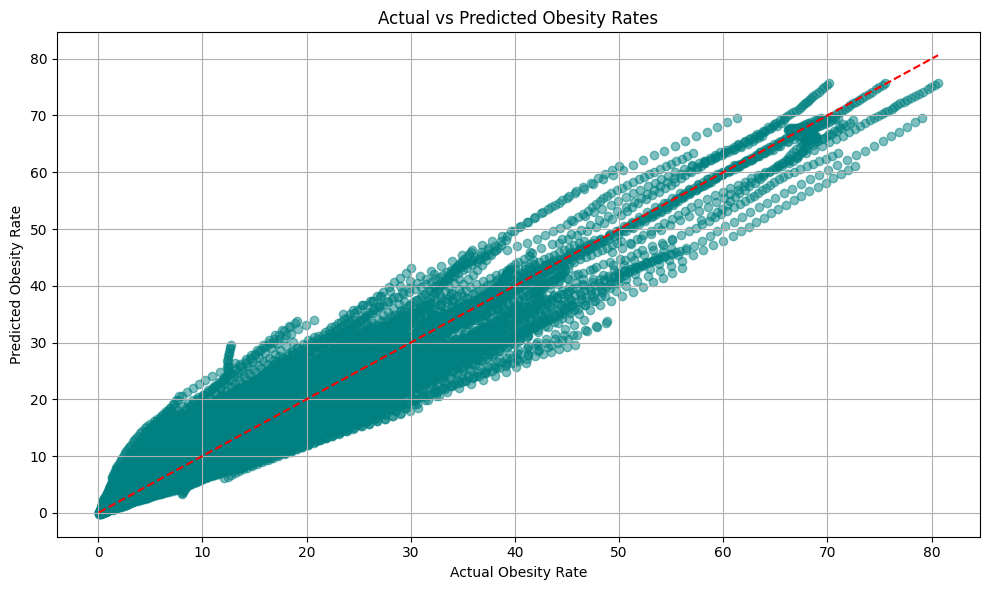

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(
    prediction_df['FactValueNumeric'],
    prediction_df['predicted_FactValueNumeric'],
    alpha=0.5,
    color='teal'
)


plt.plot(
    [prediction_df['FactValueNumeric'].min(), prediction_df['FactValueNumeric'].max()],
    [prediction_df['FactValueNumeric'].min(), prediction_df['FactValueNumeric'].max()],
    color='red', linestyle='--'
)

plt.xlabel('Actual Obesity Rate')
plt.ylabel('Predicted Obesity Rate')
plt.title('Actual vs Predicted Obesity Rates')
plt.grid(True)
plt.tight_layout()
plt.show()


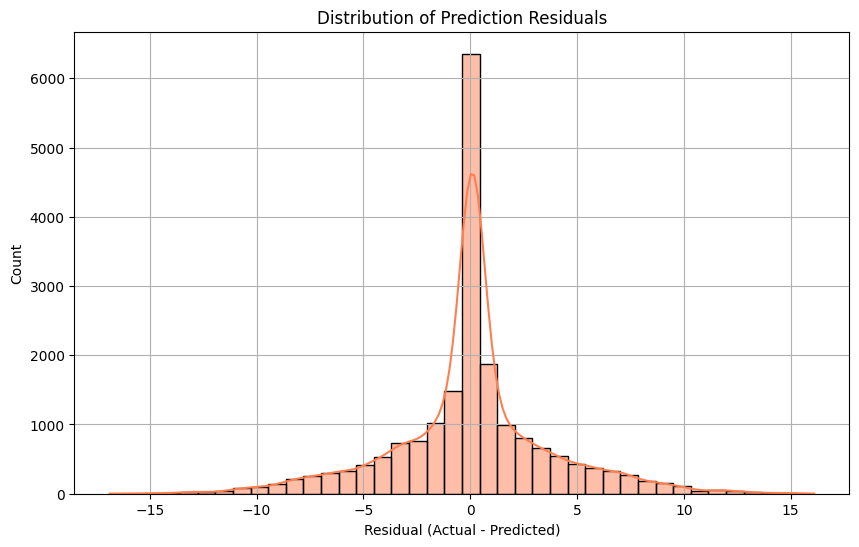

In [ ]:
import seaborn as sns

prediction_df['residuals'] = prediction_df['FactValueNumeric'] - prediction_df['predicted_FactValueNumeric']

plt.figure(figsize=(10,6))
sns.histplot(prediction_df['residuals'], bins=40, kde=True, color='coral')
plt.title('Distribution of Prediction Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


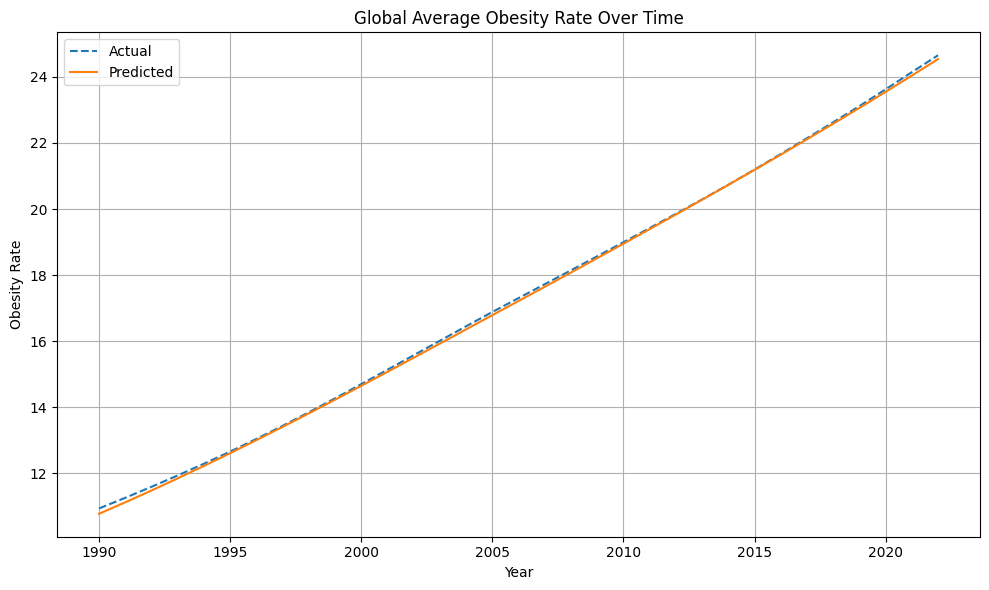

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate global average per year
global_trend = prediction_df.groupby('Period')[['FactValueNumeric', 'predicted_FactValueNumeric']].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=global_trend, x='Period', y='FactValueNumeric', label='Actual', linestyle='--')
sns.lineplot(data=global_trend, x='Period', y='predicted_FactValueNumeric', label='Predicted')
plt.title('Global Average Obesity Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Obesity Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Load the merged results CSV
df = pd.read_csv("prediction.results-00000-of-00020.csv")

# Optional: clean or rename if necessary
df.rename(columns={
    'FactValueNumeric': 'Actual',
    'predicted_FactValueNumeric': 'Predicted'
}, inplace=True)

# Calculate absolute difference between actual and predicted
df['Diff'] = abs(df['Actual'] - df['Predicted'])

# Group by country to get the most recent prediction (if there are multiple periods)
latest_df = df.sort_values('Period').drop_duplicates('Location', keep='last')

# Get top 10 countries with the highest difference
top10_diff = latest_df.nlargest(10, 'Diff')

# Create a map showing actual vs predicted obesity
fig = px.choropleth(
    top10_diff,
    locations="Location",
    locationmode="country names",
    color="Diff",
    hover_name="Location",
    hover_data={"Actual": True, "Predicted": True},
    color_continuous_scale="Reds",
    title="Top 10 Countries with Highest Discrepancy between Actual vs Predicted Obesity Rates"
)

fig.show()



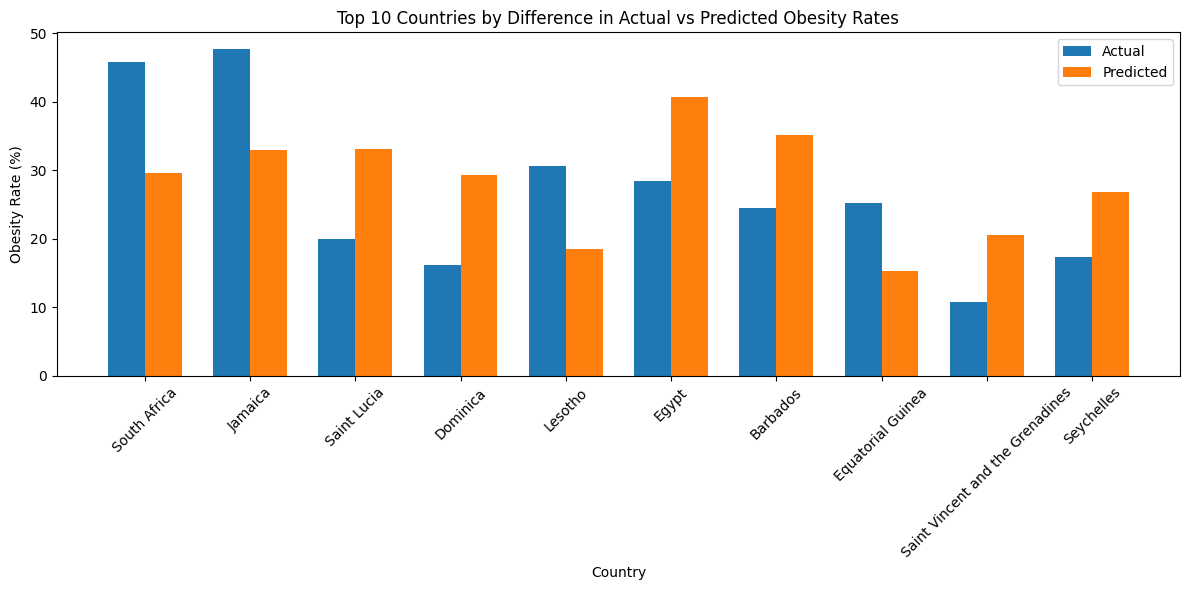

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
df = pd.read_csv('prediction.results-00000-of-00020.csv')

# Rename columns for clarity
df.rename(columns={
    'FactValueNumeric': 'Actual',
    'predicted_FactValueNumeric': 'Predicted'
}, inplace=True)

# Calculate difference between actual and predicted
df['Diff'] = abs(df['Actual'] - df['Predicted'])

# Get most recent data per country (if multiple rows per country)
df = df.sort_values('Period')  # make sure the latest year comes last
latest_df = df.drop_duplicates('Location', keep='last')

# Get top 10 countries with largest difference
top10_diff = latest_df.nlargest(10, 'Diff')

# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(top10_diff))

# Bar chart
plt.bar(index, top10_diff['Actual'], bar_width, label='Actual')
plt.bar([i + bar_width for i in index], top10_diff['Predicted'], bar_width, label='Predicted')

# Labels and aesthetics
plt.xlabel('Country')
plt.ylabel('Obesity Rate (%)')
plt.title('Top 10 Countries by Difference in Actual vs Predicted Obesity Rates')
plt.xticks([i + bar_width/2 for i in index], top10_diff['Location'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
!gsutil cp gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00000-of-00020.csv ./


Copying gs://obesity-data-bucket/prediction-obesity-regression-model-v1-2025_04_11T04_02_38_473Z/prediction.results-00000-of-00020.csv...
/ [1 files][ 50.0 KiB/ 50.0 KiB]                                                
Operation completed over 1 objects/50.0 KiB.                                     


In [ ]:
import pandas as pd

# Load the downloaded CSV file into a DataFrame
prediction_results_df = pd.read_csv('prediction.results-00000-of-00020.csv')

# Check the first few rows to make sure it's loaded correctly
print(prediction_results_df.head())


      Location         ParentLocation  Period  FactValueNumeric  \
0  New Zealand        Western Pacific    2013             30.47   
1      Bermuda               Americas    2022             34.01   
2   Cabo Verde                 Africa    2009              8.95   
3     Cameroon                 Africa    1995              2.36   
4        Qatar  Eastern Mediterranean    2019             46.01   

   predicted_FactValueNumeric  
0                   30.052378  
1                   34.066166  
2                    8.694210  
3                    4.161076  
4                   42.043076  


In [ ]:
# Check for missing values
print(prediction_results_df.isnull().sum())

# Check for data types of the columns
print(prediction_results_df.dtypes)


Location                      0
ParentLocation                0
Period                        0
FactValueNumeric              0
predicted_FactValueNumeric    0
dtype: int64
Location                       object
ParentLocation                 object
Period                          int64
FactValueNumeric              float64
predicted_FactValueNumeric    float64
dtype: object


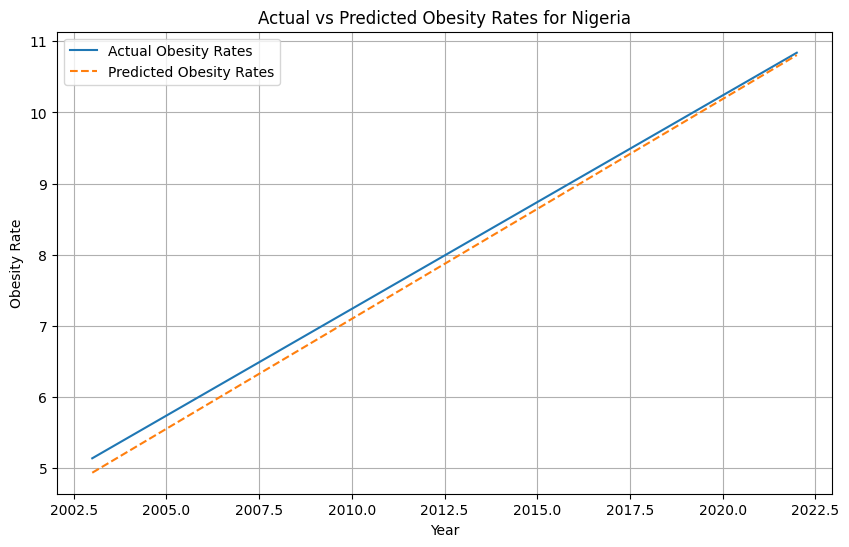

In [ ]:
import matplotlib.pyplot as plt

# Assuming prediction_results_df contains columns like 'Location', 'Period', 'FactValueNumeric', and 'predicted_FactValueNumeric'
country_data = prediction_results_df[prediction_results_df['Location'] == 'Nigeria']  # Filter for Nigeria

plt.figure(figsize=(10, 6))
plt.plot(country_data['Period'], country_data['FactValueNumeric'], label='Actual Obesity Rates')
plt.plot(country_data['Period'], country_data['predicted_FactValueNumeric'], label='Predicted Obesity Rates', linestyle='--')
plt.title('Actual vs Predicted Obesity Rates for Nigeria')
plt.xlabel('Year')
plt.ylabel('Obesity Rate')
plt.legend()
plt.grid(True)
plt.show()



# Nigeria shows a consistent increase in obesity rates from around 5% in 2003 to nearly 11% by 2022.‚Äù

That means the trend is upward ‚Äî obesity rates have more than doubled over that period. This suggests growing public health concerns tied to changing lifestyles, especially in urban areas.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [ ]:
import pandas as pd


merged_df = pd.read_csv('prediction.results-00000-of-00020.csv')


merged_df.head()


Location         ParentLocation  Period  FactValueNumeric  \
0  New Zealand        Western Pacific    2013             30.47   
1      Bermuda               Americas    2022             34.01   
2   Cabo Verde                 Africa    2009              8.95   
3     Cameroon                 Africa    1995              2.36   
4        Qatar  Eastern Mediterranean    2019             46.01   

   predicted_FactValueNumeric  
0                   30.052378  
1                   34.066166  
2                    8.694210  
3                    4.161076  
4                   42.043076

In [ ]:
#Evaluate model performance using MAE, RMSE, and R¬≤ Score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


y_true = merged_df['FactValueNumeric']
y_pred = merged_df['predicted_FactValueNumeric']


mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)


print("üìä Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R¬≤ Score: {r2:.2f}")


üìä Model Performance Metrics:
Mean Absolute Error (MAE): 2.54
Root Mean Squared Error (RMSE): 3.83
R¬≤ Score: 0.92


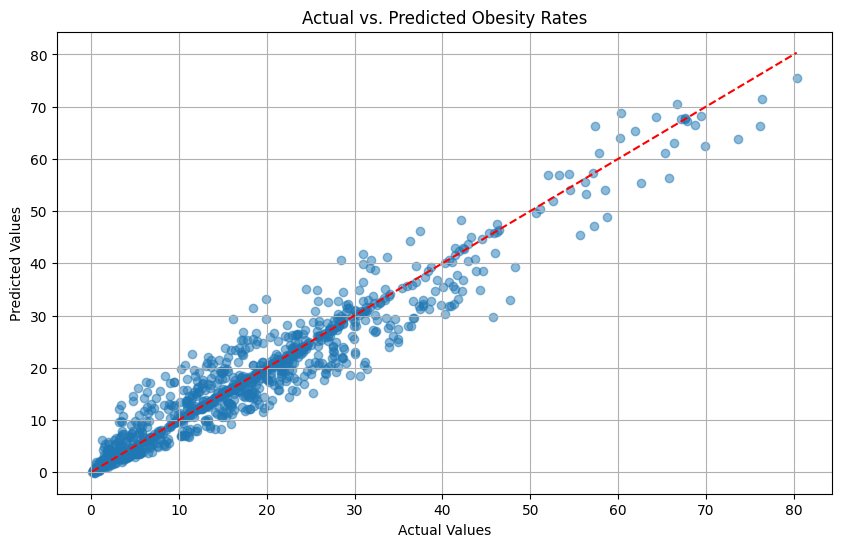

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Obesity Rates')
plt.grid(True)
plt.show()


# Global: Actual vs Predicted Obesity Rates Over Time

Observation: From around 2003 to 2022, global obesity rates increased steadily from just above 11% to nearly 25%. The predicted line tracks very closely with the actual values throughout.

Insight: The global obesity rate has more than doubled in the last two decades.

This confirms a widespread and persistent rise, likely due to increasing urbanization, processed food consumption, sedentary lifestyles, and socioeconomic changes globally.

The tight alignment of actual vs predicted values also suggests the model is effective for long-term forecasting at the macro level.